# Домашнее задание (30 баллов)

* Для задачи 1 используйте данные:[сеть](https://drive.google.com/file/d/1W5GrHAvxG4AjFm6kzwNyzoAA7jt48cJ5/view?usp=sharing), [метки вершин](https://drive.google.com/file/d/1CXh27cW2J5HzmIpqy1PFoeE_Cse7oDPW/view?usp=sharing). 

* Для задачи 2,3 [данные](https://snap.stanford.edu/data/email-Eu-core.html) (предварительно сделайте сеть ненаправленной).

In [ ]:
!pip install --upgrade matplotlib

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx 
import pandas as pd
%matplotlib inline
import gdown
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, roc_curve, auc, jaccard_score, rand_score, mutual_info_score, normalized_mutual_info_score, adjusted_rand_score, adjusted_mutual_info_score
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval
from functools import partial
import random
import itertools
from sklearn.cluster import AgglomerativeClustering
from scipy import spatial
from sklearn.manifold import spectral_embedding

In [ ]:
import warnings
warnings.filterwarnings('ignore')

## 1. Классификация вершин (10 баллов) (Регрессия)

Будем решать задачу предсказания влиятельности вершин как задачу классификации. Разобьем отрезок $\left [ s_{i}^{min},s_{i}^{max}\right ]$ на $k$ одинаковых отрезков, и разметим вершины, чьи значения $s_{i}$ лежит в $\left[s_i^{(j-1)},s_i^{(j)} \right)$, $j = 1, 2 \dots k$, меткой $j$, т.е. значение класса $l_i$ для $i$-ой вершины определяется: 

$$
l_i=\left [k \frac{s_i-s_i^{min}}{s_i^{max}-s_i^{min}}\right]. 
$$

Для k=2 задача превращается в задачу бинарной классификации. 



In [ ]:
!gdown --id 1W5GrHAvxG4AjFm6kzwNyzoAA7jt48cJ5
!gdown --id 1CXh27cW2J5HzmIpqy1PFoeE_Cse7oDPW

Downloading...
From: https://drive.google.com/uc?id=1W5GrHAvxG4AjFm6kzwNyzoAA7jt48cJ5
To: /content/ca-GrQc.mtx
100% 140k/140k [00:00<00:00, 21.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1CXh27cW2J5HzmIpqy1PFoeE_Cse7oDPW
To: /content/spreading_data_ca-GrQc.csv
100% 104k/104k [00:00<00:00, 49.5MB/s]


In [ ]:
G=nx.read_adjlist('ca-GrQc.mtx', nodetype=int)
print(G.number_of_nodes(),G.number_of_edges())

4158 13422


In [ ]:
df=pd.read_csv('spreading_data_ca-GrQc.csv')
df.head()

,node,spreading ability
0,19,0.414141
1,1,0.418711
2,1751,0.402116
3,2408,0.389610
4,3078,0.409572


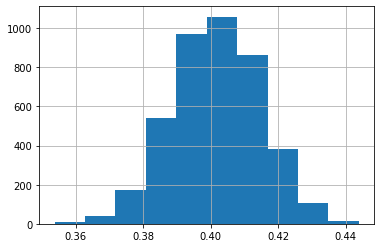

In [ ]:
df['spreading ability'].hist();

1. Вычислите различные структурные признаки вершин: центральности, кластеризацию, k-core

In [ ]:
nodes_dict = {key:0 for key in G.nodes()}
for core in range(max(dict(G.degree).values())+1):
  kG=nx.k_core(G,k=core)
  for node in kG.nodes:
    nodes_dict[node]=core

In [ ]:
df['degree_centrality'] = df['node'].map(nx.degree_centrality(G))
df['eigenvector_centrality'] = df['node'].map(nx.eigenvector_centrality(G))
df['closeness_centrality'] = df['node'].map(nx.closeness_centrality(G))
df['betweenness_centrality'] = df['node'].map(nx.betweenness_centrality(G))
df['clustering'] = df['node'].map(nx.clustering(G))
df['core'] = df['node'].map(nodes_dict)
df.set_index('node', inplace=True)

In [ ]:
df.head()

,spreading ability,degree_centrality,eigenvector_centrality,closeness_centrality,betweenness_centrality,clustering,core
node,,,,,,,
19,0.414141,0.000962,1.978526e-07,0.184101,0.002893,0.500000,3
1,0.418711,0.001443,1.930278e-08,0.159047,0.002290,0.333333,3
1751,0.402116,0.000722,1.893130e-08,0.158980,0.000000,1.000000,3
2408,0.389610,0.001203,5.769050e-07,0.171225,0.001707,0.400000,3
3078,0.409572,0.000722,1.450752e-08,0.146260,0.000481,0.333333,2


2.  Исследуйте корреляцию между признаками и целевой переменой 

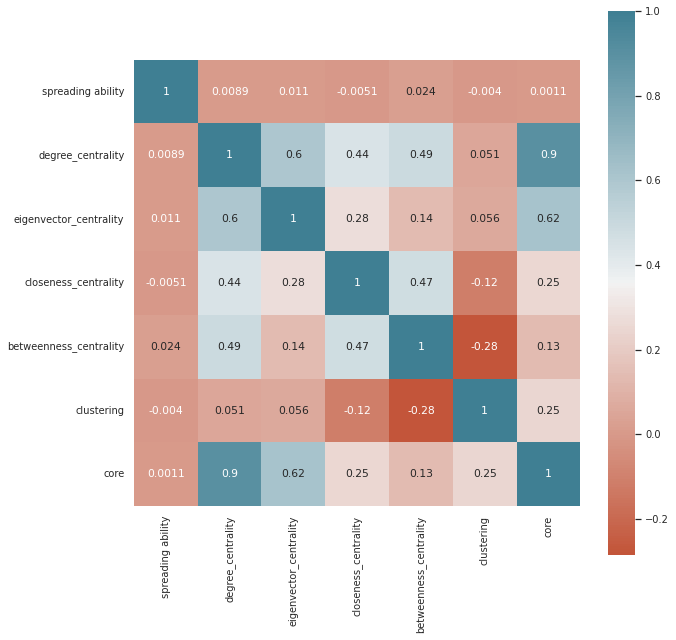

In [ ]:
sns.set(font_scale=0.9)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df.corr(), cmap=sns.diverging_palette(20, 220, n=200), square=True, annot=True);

Линейная зависимость между таргетом и признаками очень мала. \
Попробуем деревья

3. Разделите выборку на обучающую и тестовую, постройте модели классификации (бинарной), выведите метрики качества, подберите оптимальные гиперпараметры

In [ ]:
y = df['spreading ability']
X = df.drop(columns=['spreading ability'])

In [ ]:
ss = MinMaxScaler()
X = ss.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, random_state=35)

In [ ]:
models = {}
models['Decision Tree'] = DecisionTreeRegressor()
models['Random Forest'] = RandomForestRegressor()
models['GradientBoosting'] = GradientBoostingRegressor()

In [ ]:
mae, rmse, mape = {}, {}, {}

In [ ]:
def train_predict():
  for key in models.keys():
      models[key].fit(X_train, y_train) 
      predictions = models[key].predict(X_test)
      mae[key] = mean_absolute_error(y_test, predictions)
      rmse[key] = mean_squared_error(y_test, predictions, squared=False)
      mape[key] = mean_absolute_percentage_error(y_test, predictions)

In [ ]:
train_predict()
col = [('No opt', 'MAE'), ('No opt', 'RMSE'), ('No opt', 'MAPE'), ('Opt', 'MAE'), ('Opt', 'RMSE'), ('Opt', 'MAPE')]
df_model = pd.DataFrame(index=models.keys(), columns=pd.MultiIndex.from_tuples(col))
df_model[('No opt', 'MAE')] = mae.values()
df_model[('No opt', 'RMSE')] = rmse.values()
df_model[('No opt', 'MAPE')] = mape.values()
df_model

No opt                      Opt          
                       MAE      RMSE      MAPE  MAE RMSE MAPE
Decision Tree     0.014447  0.018042  0.036036  NaN  NaN  NaN
Random Forest     0.011561  0.014508  0.028814  NaN  NaN  NaN
GradientBoosting  0.010344  0.012963  0.025809  NaN  NaN  NaN

Подбор гиперпараметров с помощью Hyperopt

In [ ]:
def score(params, model, verbose=False):
    if model == 'Random Forest':
      regr = RandomForestRegressor(**params)
    elif model == 'Decision Tree':
      regr = DecisionTreeRegressor(**params)
    elif model == 'GradientBoosting':
      regr = GradientBoostingRegressor(**params)
    regr.fit(X_train, y_train)
    predictions = regr.predict(X_test)
    score = mean_squared_error(y_test, predictions, squared=False)
    if verbose:
      print("Training with params : ")
      print(params)
      print("RMSE : {0}\n".format(score))
      print('-------------------------------------------------------------------')
    return {'loss': score, 'status': STATUS_OK}


def optimize(model):
    if model == 'Random Forest':
      space = {
          'max_depth': hp.choice('max_depth', range(2,20)),
          'max_features': hp.choice('max_features', range(1,7)),
          'n_estimators': hp.choice('n_estimators', range(1,20)),
          'criterion': hp.choice('criterion', ["squared_error", "absolute_error"]),
          'random_state' : 35,
          'bootstrap' : hp.choice('bootstrap', [True, False]),
      }
    elif model == 'Decision Tree':
      space = {
          'max_depth': hp.choice('max_depth', range(2,20)),
          'max_features': hp.choice('max_features', range(1,7)),
          'criterion': hp.choice('criterion', ["squared_error", "absolute_error"]),
          'random_state' : 35
      }
    elif model == 'GradientBoosting':
      space = {
        'max_depth':hp.choice('max_depth', np.arange(3, 12, dtype=int)),
        'warm_start': hp.choice('warm_start', [True, False]),
        'max_features': hp.choice('max_features', ['auto', 'sqrt', 'log2']),
        'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
        'n_estimators': hp.choice('n_estimators', range(10, 300)),
        'random_state' : 35,
        'learning_rate' : hp.quniform('learning_rate', 0.025, 0.5, 0.025),
        'loss': hp.choice('loss', ["squared_error", "absolute_error"])
      }
    trials = Trials()
    obj = partial(score, model=model)
    best = fmin(obj, space, algo=tpe.suggest, trials=trials, max_evals=200, rstate=np.random.RandomState(35))
    print(f'Model : {model}\nBest parameters : {space_eval(space, best)}')
    print('___________________________________________________________________')

In [ ]:
for key in models.keys():
  optimize(key)

100%|██████████| 200/200 [00:11<00:00, 17.31it/s, best loss: 0.012713261368157654]
Model : Decision Tree
Best parameters : {'criterion': 'squared_error', 'max_depth': 2, 'max_features': 1, 'random_state': 35}
___________________________________________________________________
100%|██████████| 200/200 [01:22<00:00,  2.41it/s, best loss: 0.01270407529764858]
Model : Random Forest
Best parameters : {'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 4, 'max_features': 5, 'n_estimators': 10, 'random_state': 35}
___________________________________________________________________
100%|██████████| 200/200 [03:59<00:00,  1.20s/it, best loss: 0.012724695732548036]
Model : GradientBoosting
Best parameters : {'learning_rate': 0.025, 'loss': 'squared_error', 'max_depth': 8, 'max_features': 'log2', 'n_estimators': 14, 'random_state': 35, 'subsample': 0.8, 'warm_start': False}
___________________________________________________________________


In [ ]:
models['Decision Tree'] = DecisionTreeRegressor(**{'criterion': 'squared_error', 'max_depth': 2, 'max_features': 1, 'random_state': 35})
models['Random Forest'] = RandomForestRegressor(**{'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 4, 'max_features': 5, 'n_estimators': 10, 'random_state': 35})
models['GradientBoosting'] = GradientBoostingRegressor(**{'learning_rate': 0.025, 'loss': 'squared_error', 'max_depth': 8, 'max_features': 'log2', 'n_estimators': 14, 'random_state': 35, 'subsample': 0.8, 'warm_start': False})

In [ ]:
train_predict()
df_model[('Opt', 'MAE')] = mae.values()
df_model[('Opt', 'RMSE')] = rmse.values()
df_model[('Opt', 'MAPE')] = mape.values()
df_model['MAE improve (%)'] = (df_model[('Opt', 'MAE')]/df_model[('No opt', 'MAE')] - 1) * 100
df_model['RMSE improve (%)'] = (df_model[('Opt', 'RMSE')]/df_model[('No opt', 'RMSE')] - 1) * 100
df_model['MAPE improve (%)'] = (df_model[('Opt', 'MAPE')]/df_model[('No opt', 'MAPE')] - 1) * 100
df_model

No opt            ... RMSE improve (%) MAPE improve (%)
                       MAE      RMSE  ...                                  
Decision Tree     0.014447  0.018042  ...       -29.534666       -29.727602
Random Forest     0.011561  0.014508  ...       -12.436479       -11.990395
GradientBoosting  0.010344  0.012963  ...        -1.840986        -1.781152

[3 rows x 9 columns]

4. Проанализируйте важность признаков 

In [ ]:
def plot_importance():
  cols = df.drop(columns=['spreading ability']).columns
  fig, ax = plt.subplots(1, 3, figsize=(20,12), sharex=True, constrained_layout=True)
  for c, v in enumerate(models.keys()):
    sort = models[v].feature_importances_.argsort()
    ax[c].barh(cols[sort], models[v].feature_importances_[sort])
    ax[c].set_title(v)
  fig.supxlabel("Feature Importance")

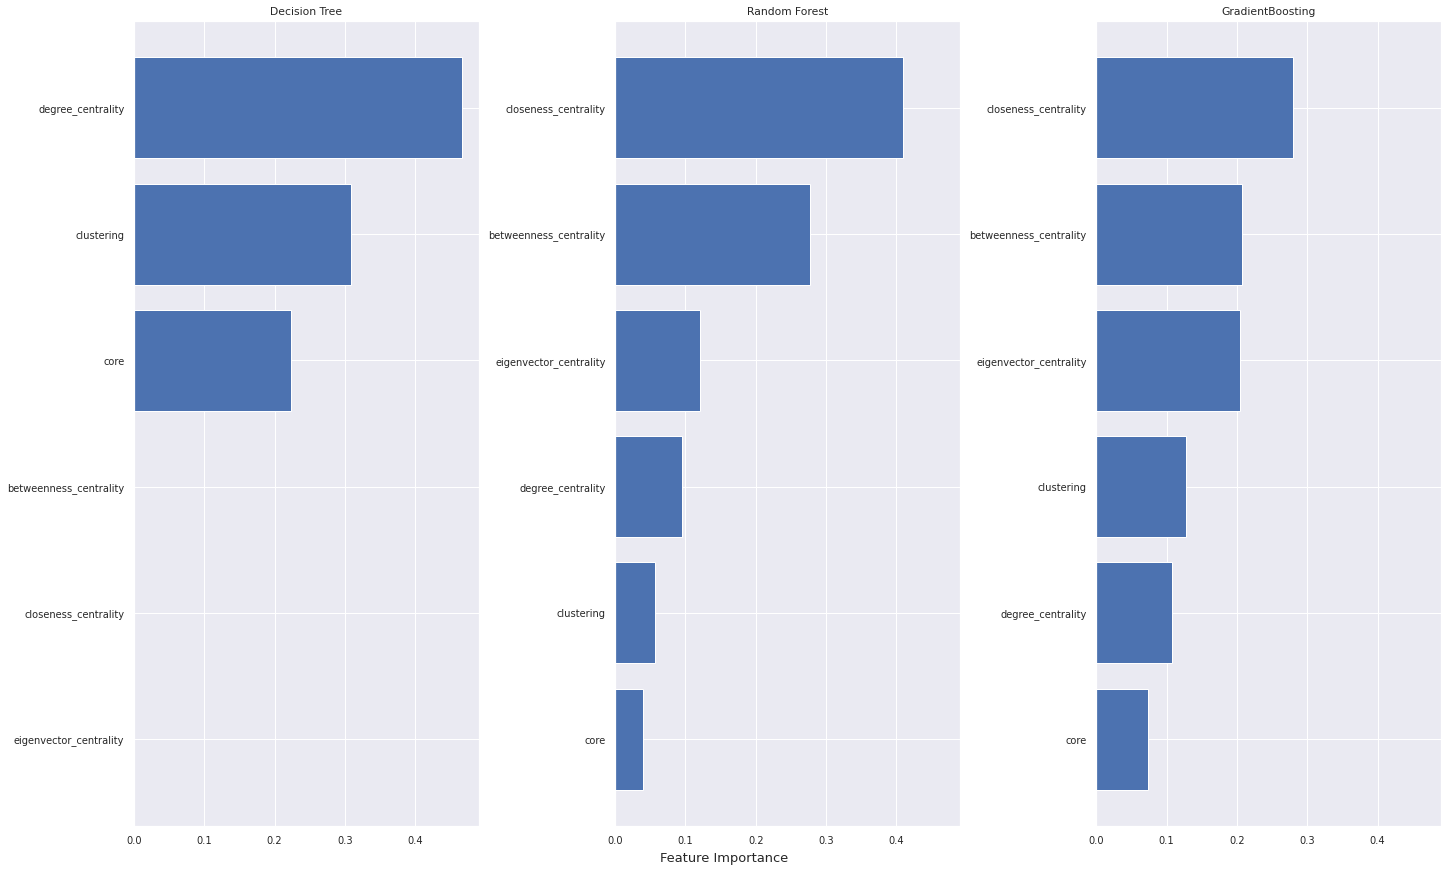

In [ ]:
plot_importance()

## 2. Предсказание связей (10 баллов)



In [ ]:
!gdown --id 1RMD0UNQ64SulwR8X_9mnwViae6hBRjlk
!gdown --id 1k860KiD2mYrm3H8WHtro1OVsjObEkw02

Downloading...
From: https://drive.google.com/uc?id=1RMD0UNQ64SulwR8X_9mnwViae6hBRjlk
To: /content/email-Eu-core.txt
100% 193k/193k [00:00<00:00, 61.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1k860KiD2mYrm3H8WHtro1OVsjObEkw02
To: /content/email-Eu-core-department-labels.txt
100% 6.54k/6.54k [00:00<00:00, 13.2MB/s]


In [ ]:
G = nx.read_adjlist('email-Eu-core.txt')
G = G.to_undirected()

In [ ]:
nx.is_connected(G)

False

In [ ]:
len(list(nx.selfloop_edges(G)))

642

In [ ]:
G.remove_edges_from(nx.selfloop_edges(G))
LCG_nodes=max(nx.connected_components(G), key=len) # максимальная компонента
G=G.subgraph(LCG_nodes) # создаем подграф на списке вершин максимальной компоненты

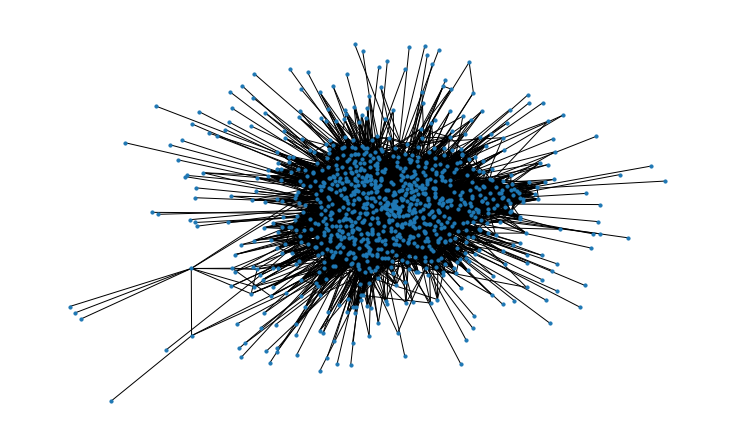

In [ ]:
plt.figure(figsize=(10,6))
pos=nx.fruchterman_reingold_layout(G) 
nx.draw(G, pos, node_size=10)

In [ ]:
print(G.number_of_nodes(),G.number_of_edges())

986 16064


1. Разбейте сеть на обучающую и тестовую выборку, тестовая выборка должна содержать как связи, которые нужно предсказать, так и отсутствующие (выберите их случайным образом, чтобы тестовая выборка была сбалансирована). 

Изначально разобьем существующие ребра на трейн и тест

In [ ]:
df = pd.DataFrame({'pair': [(u,v) for (u,v) in G.edges()]})

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.25, random_state=35)

В дальнейшем доля теста (0.25) может немного измениться, т.к. в подграфе G_train могут оказаться несколько компонент связности (что приведет к невозможности посчитать некоторые структурные характеристики), а я оставляю наибольшую компоненту (какие то узлы потеряются->потеряются возможные связи между ними(несуществующие))

In [ ]:
train_pair = df_train.pair

In [ ]:
test_pair = df_test.pair
test_pair_reverse = [t[::-1] for t in test_pair]

In [ ]:
G_train = G.copy()
G_train.remove_edges_from(test_pair)
G_train=G_train.subgraph(max(nx.connected_components(G_train), key=len))

In [ ]:
true_edges = [(u,v) for (u,v) in G_train.edges()]
non_edges = [(u,v) for (u,v,s) in list(nx.jaccard_coefficient(G_train))]
df = pd.DataFrame({'pair': true_edges+non_edges, 'target': len(true_edges)*[1]+len(non_edges)*[0]})

In [ ]:
df['target'] = np.where(df['pair'].isin(test_pair) | df['pair'].isin(test_pair_reverse), 1, df['target'])

In [ ]:
df = df[df['target'] == 1].append(df[df['target'] == 0].sample(len(df[df['target'] == 1]), random_state=35), ignore_index=True)

In [ ]:
df.target.value_counts()

1    16026
0    16026
Name: target, dtype: int64

In [ ]:
df['jaccard_coefficient'] = [s for (u, v, s) in list(nx.jaccard_coefficient(G_train, df['pair']))]
df['preferential_attachment'] = [s for (u, v, s) in list(nx.preferential_attachment(G_train, df['pair']))]
df['adamic-adar_coefficient'] = [s for (u, v, s) in list(nx.adamic_adar_index(G_train, df['pair']))]
df['common_neighbor'] = df['pair'].apply(lambda x: len(list(nx.common_neighbors(G_train, x[0], x[1]))))
df['salton_index'] = df['common_neighbor']/np.sqrt(df['preferential_attachment'])
df['degree_sum'] = df['pair'].apply(lambda x: G_train.degree(x[0]) + G_train.degree(x[0]))
df['sorensen_coefficient'] = 2 * df['common_neighbor'] / df['degree_sum']
df.drop(columns=['degree_sum'], inplace=True)

Train

In [ ]:
df_train = df[df['pair'].isin(train_pair)]
df_subset = df[df['target'] == 0].sample(len(df_train), random_state=35)
df_train = df_train.append(df_subset, ignore_index=True)
df.drop(df_subset.index, inplace=True)

In [ ]:
df_train.target.value_counts()

1    12048
0    12048
Name: target, dtype: int64

In [ ]:
y_train = df_train['target']
X_train = df_train.drop(columns=['target', 'pair'])

In [ ]:
X_train.describe().loc[['min', 'max']]

,jaccard_coefficient,preferential_attachment,adamic-adar_coefficient,common_neighbor,salton_index,sorensen_coefficient
min,0.0,1.0,0.000000,0.0,0.0,0.0
max,1.0,46475.0,30.842721,111.0,1.0,1.0


In [ ]:
cols_to_scale = ['preferential_attachment', 'adamic-adar_coefficient', 'common_neighbor']

In [ ]:
mms = MinMaxScaler()
mms.fit(X_train[cols_to_scale]) # fit на трейне, transform - на трейне и тесте
X_train[cols_to_scale] = mms.transform(X_train[cols_to_scale])

In [ ]:
X_train.describe().loc[['min', 'max']]

,jaccard_coefficient,preferential_attachment,adamic-adar_coefficient,common_neighbor,salton_index,sorensen_coefficient
min,0.0,0.0,0.0,0.0,0.0,0.0
max,1.0,1.0,1.0,1.0,1.0,1.0


In [ ]:
X_train.sample(5)

,jaccard_coefficient,preferential_attachment,adamic-adar_coefficient,common_neighbor,salton_index,sorensen_coefficient
19862,0.133333,0.005659,0.031383,0.036036,0.246183,0.181818
15978,0.000000,0.004626,0.000000,0.000000,0.000000,0.000000
8641,0.228070,0.087318,0.189957,0.234234,0.408097,0.262626
14263,0.000000,0.000710,0.000000,0.000000,0.000000,0.000000
18279,0.030928,0.053428,0.022277,0.027027,0.060193,0.065217


Test

In [ ]:
df_test = df[(df['pair'].isin(test_pair)) | (df['pair'].isin(test_pair_reverse))]
df_subset = df[df['target'] == 0].sample(len(df_test), random_state=35)
df_test = df_test.append(df_subset, ignore_index=True)
df.drop(df_subset.index, inplace=True)

In [ ]:
df_test.target.value_counts()

1    3978
0    3978
Name: target, dtype: int64

In [ ]:
y_test = df_test['target']
X_test = df_test.drop(columns=['target', 'pair'])

In [ ]:
X_test.describe().loc[['min', 'max']]

,jaccard_coefficient,preferential_attachment,adamic-adar_coefficient,common_neighbor,salton_index,sorensen_coefficient
min,0.0,1.0,0.000000,0.0,0.0,0.0
max,1.0,38500.0,23.859471,88.0,1.0,1.0


In [ ]:
X_test[cols_to_scale] = mms.transform(X_test[cols_to_scale])

In [ ]:
X_test.describe().loc[['min', 'max']]

,jaccard_coefficient,preferential_attachment,adamic-adar_coefficient,common_neighbor,salton_index,sorensen_coefficient
min,0.0,0.000000,0.000000,0.000000,0.0,0.0
max,1.0,0.828399,0.773585,0.792793,1.0,1.0


In [ ]:
X_test.sample(5)

,jaccard_coefficient,preferential_attachment,adamic-adar_coefficient,common_neighbor,salton_index,sorensen_coefficient
769,0.069307,0.289926,0.169376,0.189189,0.180907,0.428571
1076,0.025641,0.033868,0.015297,0.018018,0.050395,0.057143
7230,0.000000,0.000624,0.000000,0.000000,0.000000,0.000000
3752,0.114754,0.078797,0.127315,0.126126,0.231318,0.141414
1771,0.200000,0.032362,0.110954,0.117117,0.335101,0.302326


Реальная доля теста = $\frac{3978}{12048}\approx0.33$

2. Сравните Roc-кривые для различных структурных характеристик ребер в сети. Какая лучше справляется с задачей предсказания связей по AUC ROC? 

Подсчет AUC ROC и построение ROC везде далее по коду делается на тестовой выборке

In [ ]:
def ROC_curve(y_true, y_pred, title='common_neighbor'):
  fpr, tpr, thresholds = roc_curve(y_true, y_pred)
  a = auc(fpr, tpr)
  print(f'{title} : AUC ROC = {a}')
  plt.plot(fpr,tpr,'--', label=title)
  plt.plot([0, 1], [0, 1], color="navy",  linestyle="--")
  plt.xlabel("False Positive Rate", fontsize=14)
  plt.ylabel("True Positive Rate", fontsize=14)
  plt.title(title)
  return a

Число общих соседей

In [ ]:
AUC_ROC = {}

common_neighbor : AUC ROC = 0.9332950445651182


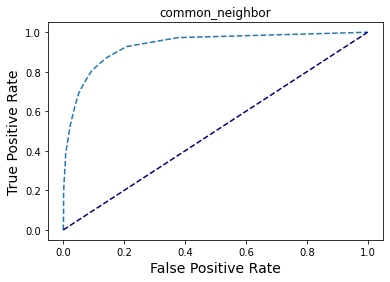

In [ ]:
AUC_ROC['common_neighbor'] = ROC_curve(y_test, X_test['common_neighbor'])

Индекс Салтона

salton_index : AUC ROC = 0.9240759129965946


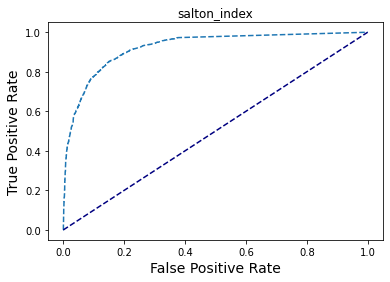

In [ ]:
AUC_ROC['salton_index'] = ROC_curve(y_test, X_test['salton_index'], title = 'salton_index')

Коэффициент Жаккара

jaccard_coefficient : AUC ROC = 0.9210662414016154


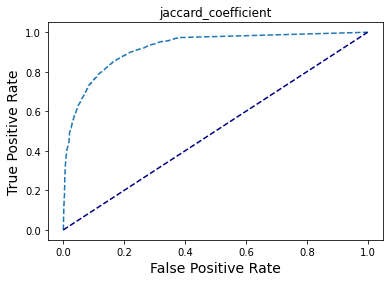

In [ ]:
AUC_ROC['jaccard_coefficient'] = ROC_curve(y_test, X_test['jaccard_coefficient'], title = 'jaccard_coefficient')

Коэффициент Серенсена

sorensen_coefficient : AUC ROC = 0.8869698057769215


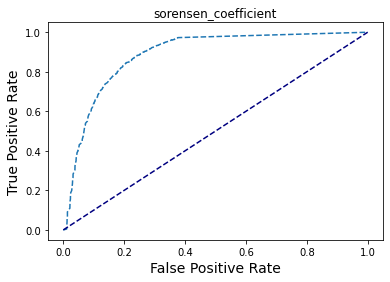

In [ ]:
AUC_ROC['sorensen_coefficient'] = ROC_curve(y_test, X_test['sorensen_coefficient'], title = 'sorensen_coefficient')

Коэффициент предпочтительного присоединения

preferential_attachment : AUC ROC = 0.8557746969822208


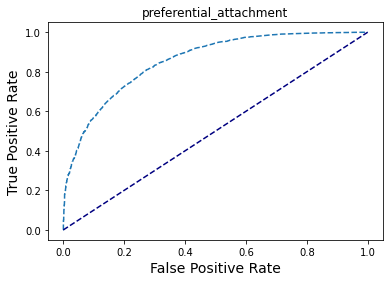

In [ ]:
AUC_ROC['preferential_attachment'] = ROC_curve(y_test, X_test['preferential_attachment'], title = 'preferential_attachment')

Коэффициент Адамика-Адара

adamic-adar_coefficient : AUC ROC = 0.9394500951816187


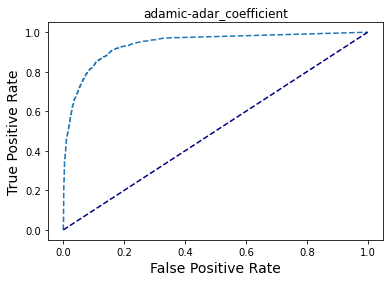

In [ ]:
AUC_ROC['adamic-adar_coefficient'] = ROC_curve(y_test, X_test['adamic-adar_coefficient'], title = 'adamic-adar_coefficient')

По AUC ROC лучше всех справляется коэффициент Адамика-Адара.

3. Постройте модель классификации, используя структурные признаки, улучшилось ли качество предсказания?

In [ ]:
models = {}
models['Logistic Regression'] = LogisticRegression()
models['Naive Bayes'] = GaussianNB()
models['Decision Tree'] = DecisionTreeClassifier()
models['KNN'] = KNeighborsClassifier()

In [ ]:
def train_predict2():
  fig, ax = plt.subplots(figsize=(14,8))
  for i, key in enumerate(models.keys()):
      models[key].fit(X_train, y_train) 
      predictions = models[key].predict_proba(X_test)[:,1]
      fpr, tpr, thresholds = roc_curve(y_test, predictions)
      AUC_ROC[key] = auc(fpr, tpr)
      ax.plot(fpr,tpr,'--', label=key)
  ax.plot([0, 1], [0, 1], color="black",  linestyle="--")
  ax.set_xlabel("False Positive Rate", fontsize=14)
  ax.set_ylabel("True Positive Rate", fontsize=14)
  ax.legend()

,No opt,Opt
,AUC ROC,AUC ROC
adamic-adar_coefficient,0.939450,NaN
Logistic Regression,0.933897,NaN
common_neighbor,0.933295,NaN
Naive Bayes,0.930721,NaN
salton_index,0.924076,NaN
jaccard_coefficient,0.921066,NaN
sorensen_coefficient,0.886970,NaN
KNN,0.879174,NaN
preferential_attachment,0.855775,NaN


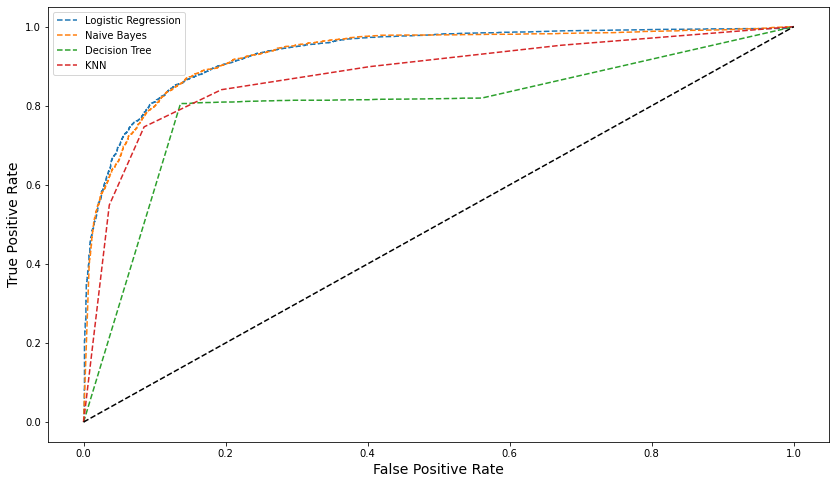

In [ ]:
train_predict2()
col = [('No opt', 'AUC ROC'),  ('Opt', 'AUC ROC')]
df_model2 = pd.DataFrame(index=AUC_ROC.keys(), columns=pd.MultiIndex.from_tuples(col))
df_model2[('No opt', 'AUC ROC')] = AUC_ROC.values()
df_model2.sort_values([('No opt', 'AUC ROC')], ascending=False)

Без подбора гиперпараметров результаты схожи с предсказаниями структурными характеристиками (но лидирует коэффициент Адамика-Адара)

Подбор гиперпараметров

In [ ]:
def score(params, model, verbose=False):
    if model == 'Logistic Regression':
      clas = LogisticRegression(**params)
    elif model == 'Naive Bayes':
      clas = GaussianNB(**params)
    elif model == 'KNN':
      clas = KNeighborsClassifier()
    elif model == 'Decision Tree':
      clas = DecisionTreeClassifier(**params)
    clas.fit(X_train, y_train)
    predictions = clas.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, predictions)
    score = auc(fpr, tpr)
    if verbose:
      print("Training with params : ")
      print(params)
      print("RMSE : {0}\n".format(score))
      print('-------------------------------------------------------------------')
    return {'loss': -score, 'status': STATUS_OK}


def optimize(model):
    if model == 'Logistic Regression':
      space = {
          'penalty': hp.choice('penalty', ["elasticnet", "l1", "l2", "none"]),
          'C': hp.choice('C', range(1,5)),
          'max_iter': 1000,
          'solver': hp.choice('solver', ["saga"]),
          'random_state' : 35,
          'l1_ratio': hp.choice('l1_ratio', np.arange(0, 1.01, 0.1)),
      }
    elif model == 'Naive Bayes':
      space = {
          'priors' : None, 
          'var_smoothing' : 1e-09
      }
    elif model == 'KNN':
      space = {
        'n_neighbors':hp.choice('n_neighbors', np.arange(3, 15, dtype=int)),
        'weights': hp.choice('weights', ["uniform", "distance"]),
        'algorithm': hp.choice('algorithm', ["auto", "ball_tree", "kd_tree", "brute"]),
        'p': hp.choice('p', [1, 2])
      }
    elif model == 'Decision Tree':
      space = {
        'criterion':hp.choice('criterion', ["gini", "entropy"]),
        'splitter':hp.choice('splitter', ["best", "random"]),
        'max_depth': hp.choice('max_depth', range(2, 30)),
        'max_features': hp.choice('max_features', ['auto', 'sqrt', 'log2']),
        'min_samples_split': hp.choice('min_samples_split', range(2, 9)),
        'min_samples_leaf': hp.choice('min_samples_leaf', range(1, 6)),
        'random_state' : 35
      }
    trials = Trials()
    obj = partial(score, model=model)
    best = fmin(obj, space, algo=tpe.suggest, trials=trials, max_evals=200, rstate=np.random.RandomState(35))
    print(f'Model : {model}\nBest parameters : {space_eval(space, best)}')
    print('___________________________________________________________________')

In [ ]:
for key in models.keys():
  optimize(key)

100%|██████████| 200/200 [08:26<00:00,  2.53s/it, best loss: -0.9405264651915349]
Model : Logistic Regression
Best parameters : {'C': 3, 'l1_ratio': 0.7000000000000001, 'max_iter': 1000, 'penalty': 'none', 'random_state': 35, 'solver': 'saga'}
___________________________________________________________________
100%|██████████| 200/200 [00:02<00:00, 72.54it/s, best loss: -0.930721342951846]
Model : Naive Bayes
Best parameters : {'priors': None, 'var_smoothing': 1e-09}
___________________________________________________________________
100%|██████████| 200/200 [00:12<00:00, 16.21it/s, best loss: -0.9367380320268262]
Model : Decision Tree
Best parameters : {'criterion': 'entropy', 'max_depth': 6, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 8, 'random_state': 35, 'splitter': 'best'}
___________________________________________________________________
100%|██████████| 200/200 [00:19<00:00, 10.28it/s, best loss: -0.8791739749618376]
Model : KNN
Best parameters : {'algo

In [ ]:
models['Logistic Regression'] = LogisticRegression(**{'C': 3, 'l1_ratio': 0.7000000000000001, 'max_iter': 1000, 'penalty': 'none', 'random_state': 35, 'solver': 'saga'})
models['Naive Bayes'] = GaussianNB(**{'priors': None, 'var_smoothing': 1e-09})
models['Decision Tree'] = DecisionTreeClassifier(**{'criterion': 'entropy', 'max_depth': 6, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 8, 'random_state': 35, 'splitter': 'best'})
models['KNN'] = KNeighborsClassifier(**{'algorithm': 'auto', 'n_neighbors': 11, 'p': 2, 'weights': 'uniform'})

,No opt,Opt,AUC ROC improve (%)
,AUC ROC,AUC ROC,
Logistic Regression,0.933897,0.940526,0.709920
adamic-adar_coefficient,0.939450,0.939450,0.000000
Decision Tree,0.799925,0.936738,17.103190
common_neighbor,0.933295,0.933295,0.000000
Naive Bayes,0.930721,0.930721,0.000000
salton_index,0.924076,0.924076,0.000000
jaccard_coefficient,0.921066,0.921066,0.000000
KNN,0.879174,0.905015,2.939236
sorensen_coefficient,0.886970,0.886970,0.000000


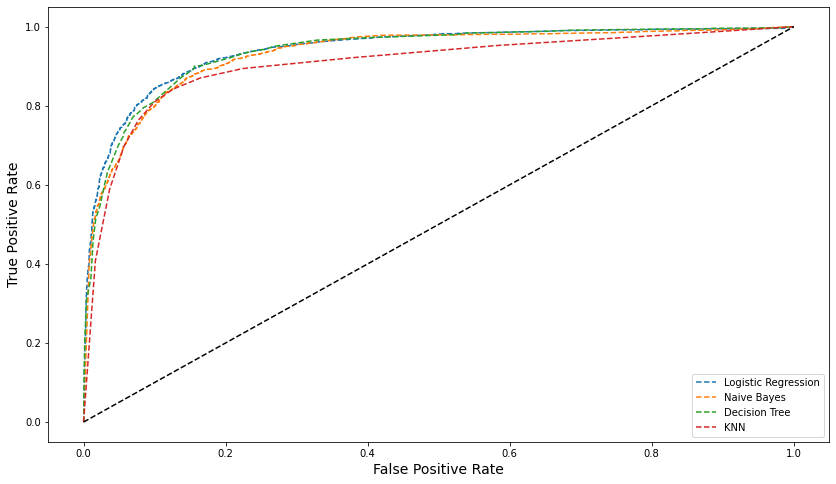

In [ ]:
train_predict2()
df_model2[('Opt', 'AUC ROC')] = AUC_ROC.values()
df_model2['AUC ROC improve (%)'] = (df_model2[('Opt', 'AUC ROC')]/df_model2[('No opt', 'AUC ROC')] - 1) * 100
df_model2.sort_values([('Opt', 'AUC ROC')], ascending=False)

После подбора гиперпараметров лучшей по AUC ROC оказалась логистическая регрессия

4. Постройте модель предсказания на основе вложения (используйте вложение сети с помощью Лапласиана или Node2vec, на выбор) Сравните качество предсказания для разных размерностей используемого пространства $d$. 

In [ ]:
df_2_test = df_test.copy()

In [ ]:
df_2_test.sample(3)

,pair,target,jaccard_coefficient,preferential_attachment,adamic-adar_coefficient,common_neighbor,salton_index,sorensen_coefficient
7082,"(194, 601)",0,0.084746,999,1.238853,5,0.158193,0.135135
2044,"(427, 119)",1,0.106383,507,1.575794,5,0.222058,0.128205
5440,"(928, 11)",0,0.018519,54,0.209988,1,0.136083,1.000000


In [ ]:
def spectral_df(max_dim = 256, step = 4):
  aucs = {}
  figure = plt.figure(figsize=(14,8))
  for dim in range(2, max_dim+1, step):
    a=nx.to_numpy_array(G_train)
    emb = spectral_embedding(a, n_components=dim, norm_laplacian=True, random_state=35)
    emb = {list(G_train.nodes())[i] : emb[i] for i in range(len(G_train.nodes()))}
    df_2_test['cosine_measure'] = [1 - spatial.distance.cosine(emb[i], emb[j]) for (i,j) in df_2_test.pair] # косинусное сходство
    fpr, tpr, thresholds = roc_curve(df_2_test.target, df_2_test.cosine_measure)
    aucs[dim] = auc(fpr, tpr)
    plt.plot(fpr,tpr,'--', label=str(dim))
  plt.legend(title="Размерность:", frameon=True)
  plt.plot([0, 1], [0, 1], color="black",  linestyle="--")
  plt.xlabel("False Positive Rate", fontsize=14)
  plt.ylabel("True Positive Rate", fontsize=14)
  return aucs

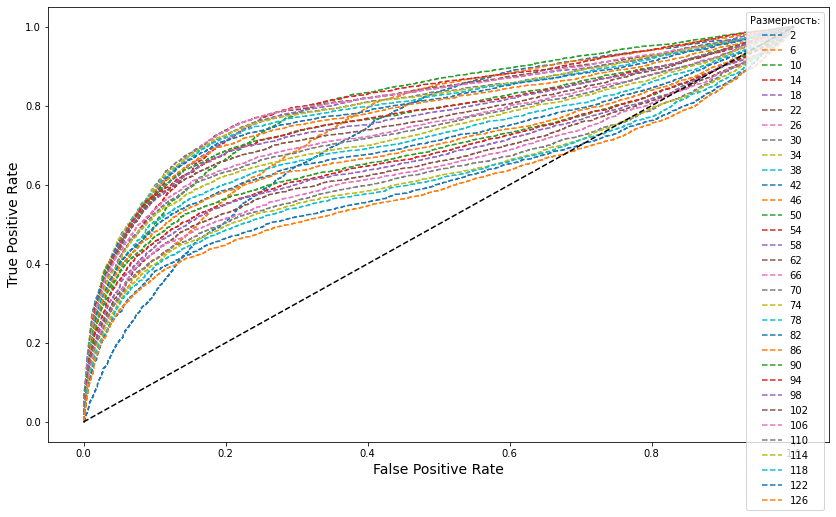

In [ ]:
aucs = spectral_df(128)

Возьмем три лучших результата в таблицу для сравнения

In [ ]:
ss = np.array([i[1] for i in sorted(aucs.items(), key=lambda x: x[1])[-3:]]).reshape(3,-1)

In [ ]:
df_emb = pd.DataFrame(data=np.concatenate((ss,ss), axis=1), index=['Косинусное сходство вложений (размерность: '+str(i[0])+')' for i in sorted(aucs.items(), key=lambda x: x[1])[-3:]], columns=pd.MultiIndex.from_tuples(col))
df_emb['AUC ROC improve (%)'] = 0

In [ ]:
df_model2.append(df_emb).sort_values([('Opt', 'AUC ROC')], ascending=False)

,No opt,Opt,AUC ROC improve (%)
,AUC ROC,AUC ROC,
Logistic Regression,0.933897,0.940526,0.709920
adamic-adar_coefficient,0.939450,0.939450,0.000000
Decision Tree,0.799925,0.936738,17.103190
common_neighbor,0.933295,0.933295,0.000000
Naive Bayes,0.930721,0.930721,0.000000
salton_index,0.924076,0.924076,0.000000
jaccard_coefficient,0.921066,0.921066,0.000000
KNN,0.879174,0.905015,2.939236
sorensen_coefficient,0.886970,0.886970,0.000000


Лучшей осталась логистическая регрессия

## 3. Задача кластеризации (10 баллов)

 Каждый сотдрудник относится к одному из департаментов, которые и являются истинными сообществами в сети. 

In [ ]:
!gdown --id 1RMD0UNQ64SulwR8X_9mnwViae6hBRjlk
!gdown --id 1k860KiD2mYrm3H8WHtro1OVsjObEkw02

Downloading...
From: https://drive.google.com/uc?id=1RMD0UNQ64SulwR8X_9mnwViae6hBRjlk
To: /content/email-Eu-core.txt
100% 193k/193k [00:00<00:00, 13.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1k860KiD2mYrm3H8WHtro1OVsjObEkw02
To: /content/email-Eu-core-department-labels.txt
100% 6.54k/6.54k [00:00<00:00, 4.36MB/s]


In [ ]:
G = nx.read_adjlist('email-Eu-core.txt', nodetype=int)
G = G.to_undirected()

In [ ]:
departs = pd.read_csv('email-Eu-core-department-labels.txt', sep=" ", header=None, names=['node','department'])
departs

,node,department
0,0,1
1,1,1
2,2,21
3,3,21
4,4,21
...,...,...
1000,1000,4
1001,1001,21
1002,1002,1
1003,1003,6


In [ ]:
len(departs.department.unique())

42

1. Постройте распределение размеров сообществ в сети, какова доля вершин в наибольшем сообществе? В наименьшем? 

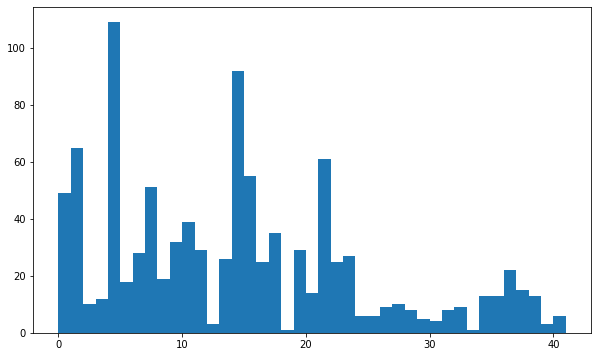

In [ ]:
plt.figure(figsize=(10,6))
n, bins, _ = plt.hist(departs.department, bins=41);

In [ ]:
print(f'Наибольшее сообщество - {n.argmax()}; Количество узлов - {n[n.argmax()]:.0f}, доля от всех узлов = {n[n.argmax()]/n.sum():.3f}')

Наибольшее сообщество - 4; Количество узлов - 109, доля от всех узлов = 0.108


In [ ]:
print(f'Наименьшее сообщество - {n.argmin()}; Количество узлов - {n[n.argmin()]:.0f}, доля от всех узлов = {n[n.argmin()]/n.sum():.3f}')

Наименьшее сообщество - 18; Количество узлов - 1, доля от всех узлов = 0.001


2. Рассмотрим задачу поиска сообществ с помощью агломеративного метода, постройте зависимость метрик качества от числа задаваемых сообществ. 
Какое разбиение оказывается более близким к истинному? 

In [ ]:
colors = [departs.department[node] for node in G.nodes()]

In [ ]:
def similarity_matrix(G, nodelist=None): # nodelist задает порядок строк в матрице
    if (nodelist is None):
        nodelist=list(G.nodes)

    Smatrix=np.zeros((len(nodelist), len(nodelist)))

    for i, node1 in enumerate(nodelist):
        for j, node2 in enumerate(nodelist[i+1:], start = i+1):
            Smatrix[i,j]=(len(set(G[node1]) & set(G[node2])) + int(G.has_edge(node1,node2)))/(np.min([len(G[node1]),len(G[node2])])
                                                                                          +1-int(G.has_edge(node1,node2)))
            Smatrix[j,i]=Smatrix[i,j]

    return Smatrix

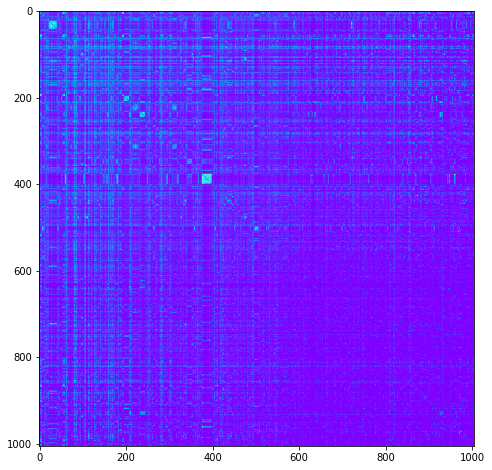

In [ ]:
plt.figure(figsize=(12, 8))
plt.imshow(similarity_matrix(G, nodelist=None), cmap='rainbow'); # порядок вершин произвольный

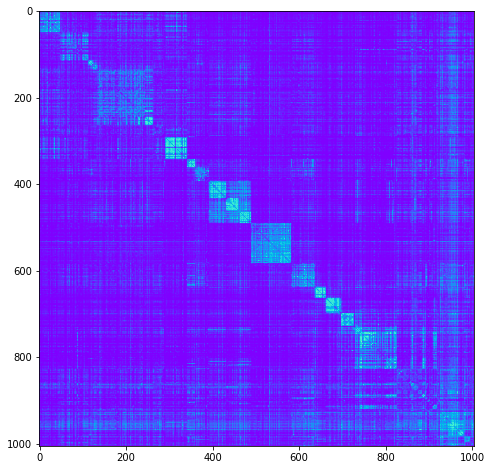

In [ ]:
plt.figure(figsize=(12, 8))
plt.imshow(similarity_matrix(G, nodelist=list(np.argsort(colors))), cmap='rainbow'); # вершины отсортированы по принадлежности к сообществам

In [ ]:
def aggl_cluster(c=42):
  rand_scores = []
  arand_scores = []
  jaccard_scores = []
  mutual_scores = []
  nmutual_scores = []
  amutual_scores = []
  for i in range(1, c+1):
    communities = AgglomerativeClustering(linkage='average', n_clusters = i)
    X=similarity_matrix(G, nodelist=None)
    communities.fit(X)
    y_pred=communities.labels_
    y_true=np.array(colors)
    rand_scores.append(rand_score(y_true, y_pred))
    arand_scores.append(adjusted_rand_score(y_true, y_pred))
    jaccard_scores.append(jaccard_score(y_true, y_pred, average='micro'))
    mutual_scores.append(mutual_info_score(y_true, y_pred))
    nmutual_scores.append(normalized_mutual_info_score(y_true, y_pred, average_method='geometric'))
    amutual_scores.append(adjusted_mutual_info_score(y_true, y_pred))
  return rand_scores, arand_scores, jaccard_scores, mutual_scores, nmutual_scores, amutual_scores

In [ ]:
%%time
rands, arands, jaccs, muts, nmuts, amuts = aggl_cluster(100)

CPU times: user 28min 39s, sys: 2min 25s, total: 31min 4s
Wall time: 29min 42s


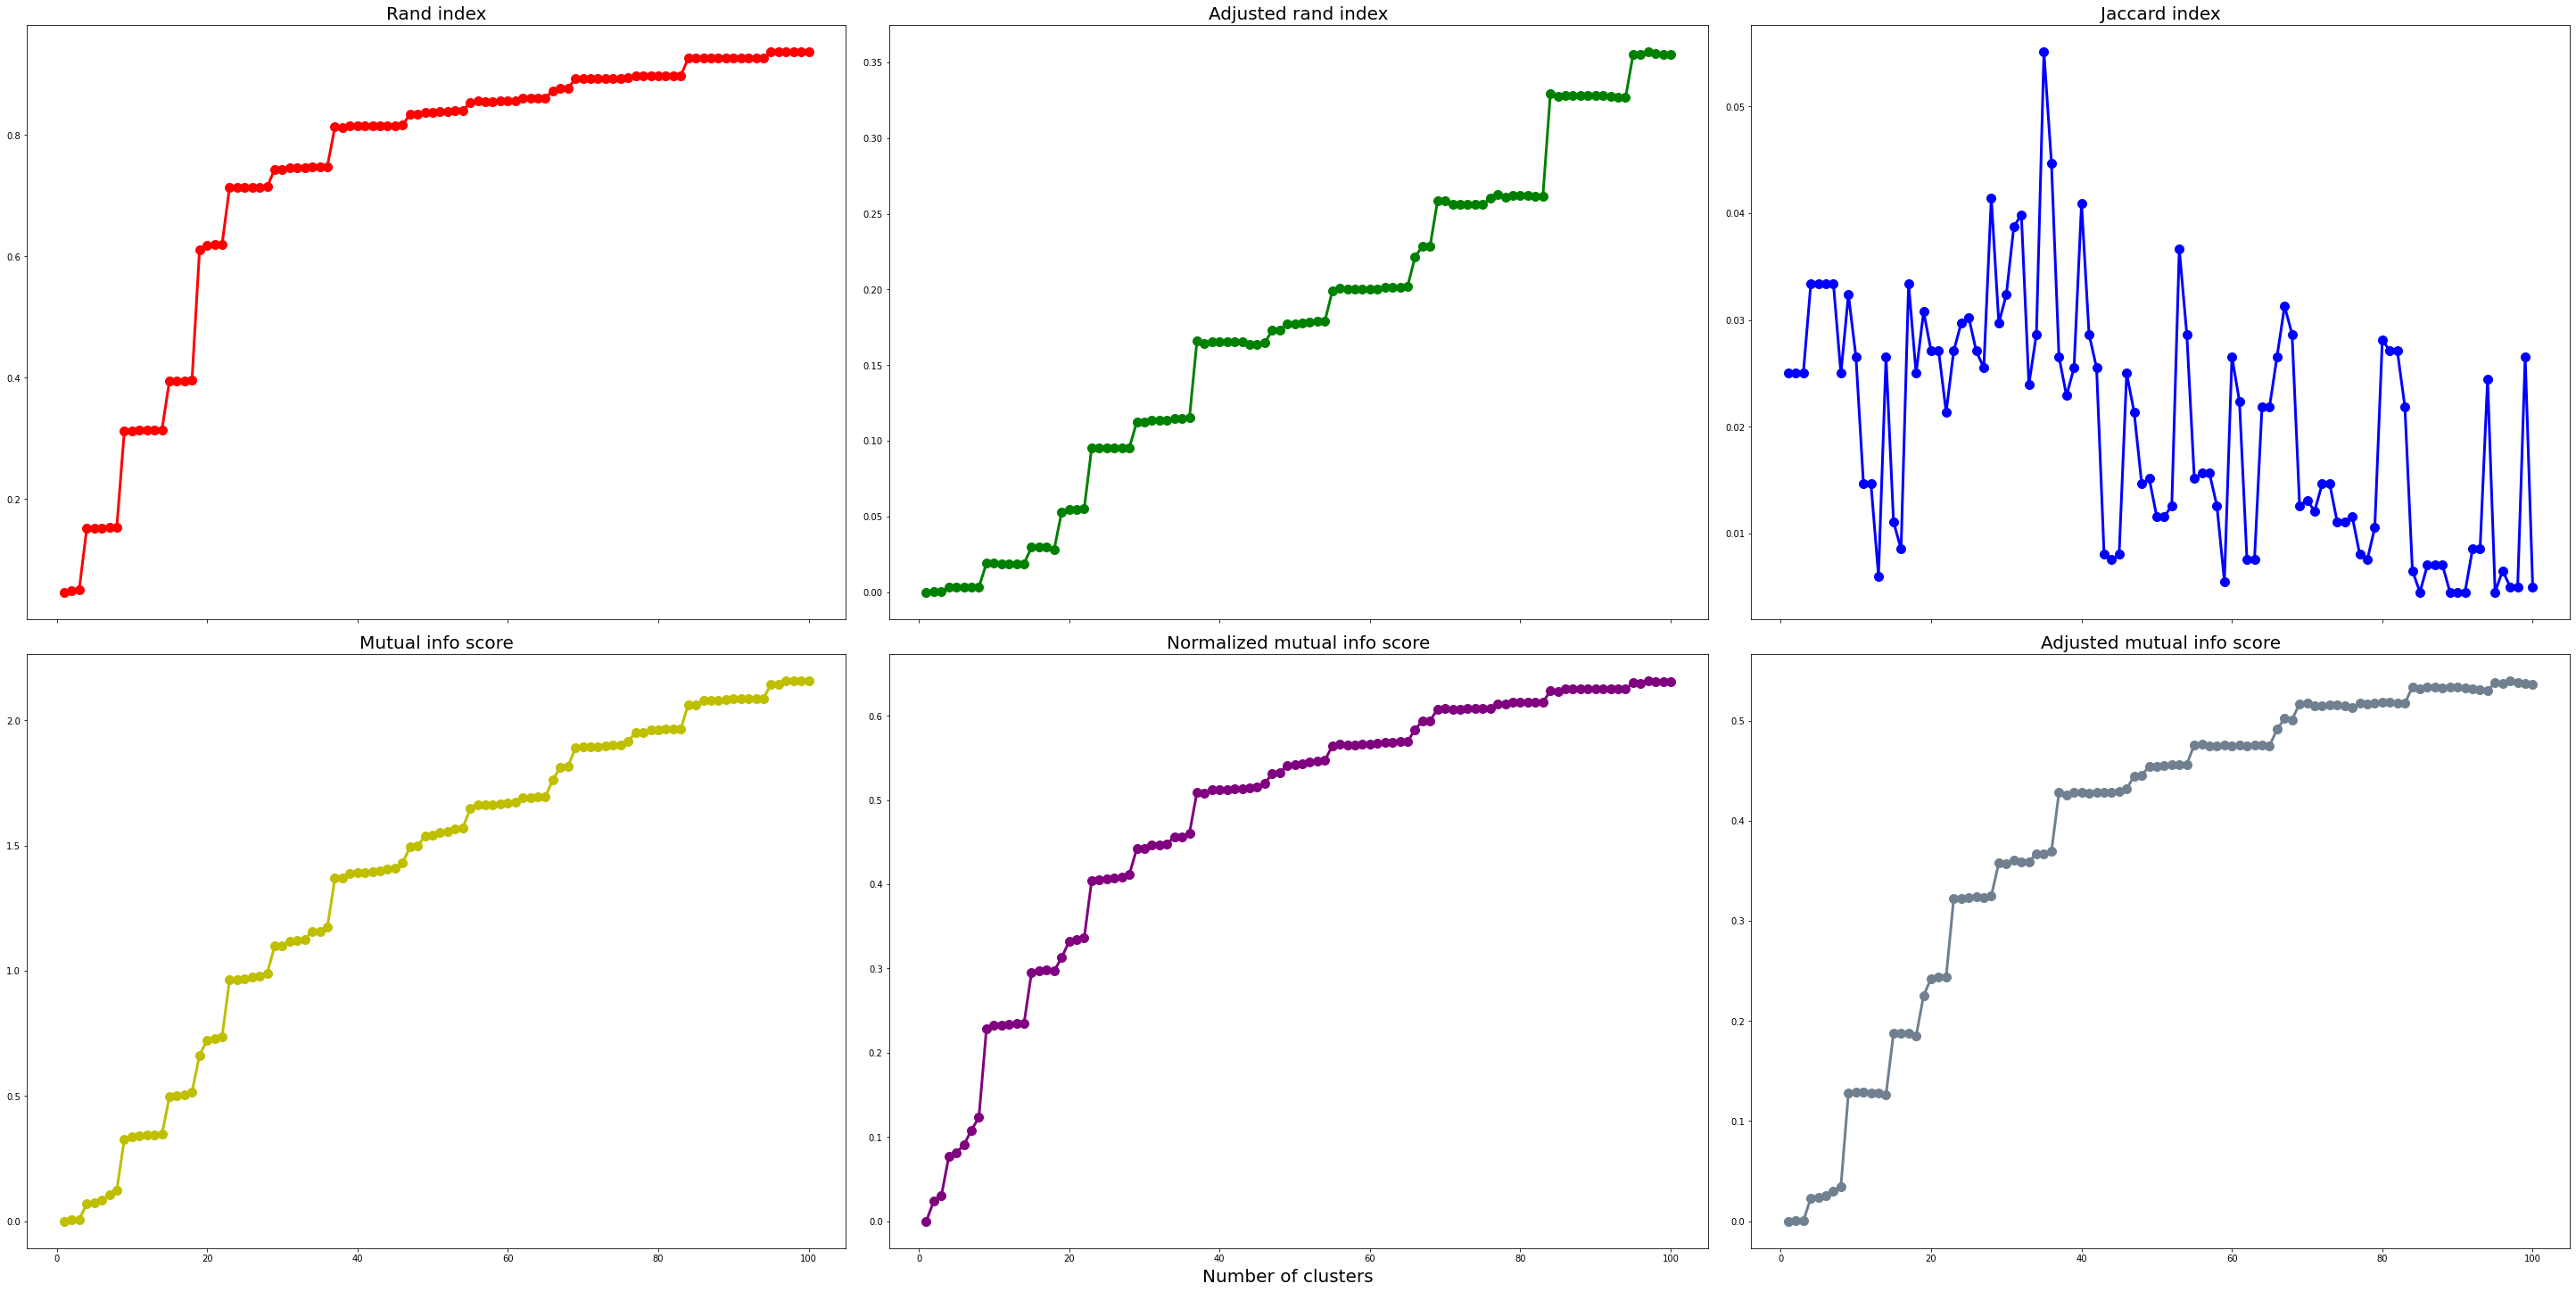

In [ ]:
f, ax = plt.subplots(2, 3, figsize=(40,20), constrained_layout=True, sharex=True)
clusters = np.arange(1, len(rands)+1, 1)
ax[0, 0].plot(clusters, rands, 'ro-', linewidth=3, markersize=10)
ax[0, 0].set_title('Rand index', fontsize=20)
ax[0, 1].plot(clusters, arands, 'go-', linewidth=3, markersize=10)
ax[0, 1].set_title('Adjusted rand index', fontsize=20)
ax[0, 2].plot(clusters, jaccs, 'bo-', linewidth=3, markersize=10)
ax[0, 2].set_title('Jaccard index', fontsize=20)
ax[1, 0].plot(clusters, muts, 'yo-', linewidth=3, markersize=10)
ax[1, 0].set_title('Mutual info score', fontsize=20)
ax[1, 1].plot(clusters, nmuts, 'o-', color='purple', linewidth=3, markersize=10)
ax[1, 1].set_title('Normalized mutual info score', fontsize=20)
ax[1, 2].plot(clusters, amuts, 'o-', color='slategray', linewidth=3, markersize=10)
ax[1, 2].set_title('Adjusted mutual info score', fontsize=20)
f.supxlabel("Number of clusters", fontsize=20);

In [ ]:
print(f'Лучшее разбиение (количество сообществ) :\nRand index : {clusters[np.argmax(rands)]}\n\
Adjusted rand index : {clusters[np.argmax(arands)]}\nJaccard index : {clusters[np.argmax(jaccs)]}\nMutual info score : {clusters[np.argmax(muts)]}\n\
Normalized mutual info score : {clusters[np.argmax(nmuts)]}\nAdjusted mutual info score : {clusters[np.argmax(amuts)]}')

Лучшее разбиение (количество сообществ) :
Rand index : 97
Adjusted rand index : 97
Jaccard index : 35
Mutual info score : 99
Normalized mutual info score : 97
Adjusted mutual info score : 97


3. Выполните пункт 2) для алгоритма Гирвана-Ньюмана. Сравните качество агломеративного метода и Гирвана-Ньюмана. 

[Использование girvan_newman из nx](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.centrality.girvan_newman.html)

[Алгоритм Гирвана-Ньюмана](https://ru.wikipedia.org/wiki/%D0%90%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC_%D0%93%D0%B8%D1%80%D0%B2%D0%B0%D0%BD_%E2%80%94_%D0%9D%D1%8C%D1%8E%D0%BC%D0%B5%D0%BD%D0%B0)

In [ ]:
def girvan_newman(c):
  communities = []
  comp = nx.algorithms.community.centrality.girvan_newman(G)
  cluster_labels = {} # словарь словарей (число сообществ : {вершина:сообщество})
  limited = itertools.takewhile(lambda x: len(x) <= c, comp)
  for comms in limited:
    communities.append(tuple(sorted(x) for x in comms))
  for i in communities:
    labels = {}
    for k, v in enumerate(i):
      for n in v:
        labels[n] = k
    cluster_labels[len(i)] = labels
  return cluster_labels

In [ ]:
def metrics_girvan_newman(c=42):
  rand_scores = {}
  arand_scores = {}
  jaccard_scores = {}
  mutual_scores = {}
  nmutual_scores = {}
  amutual_scores = {}
  c_l = girvan_newman(c)
  y_true=np.array(colors)
  for k,v in c_l.items():
    y_pred = [v[n] for n in G.nodes()]
    rand_scores[k] = rand_score(y_true, y_pred)
    arand_scores[k] = adjusted_rand_score(y_true, y_pred)
    jaccard_scores[k] = jaccard_score(y_true, y_pred, average='micro')
    mutual_scores[k] = mutual_info_score(y_true, y_pred)
    nmutual_scores[k] = normalized_mutual_info_score(y_true, y_pred, average_method='geometric')
    amutual_scores[k] = adjusted_mutual_info_score(y_true, y_pred)
  return rand_scores, arand_scores, jaccard_scores, mutual_scores, nmutual_scores, amutual_scores

In [ ]:
rands, arands, jaccs, muts, nmuts, amuts = metrics_girvan_newman(100)

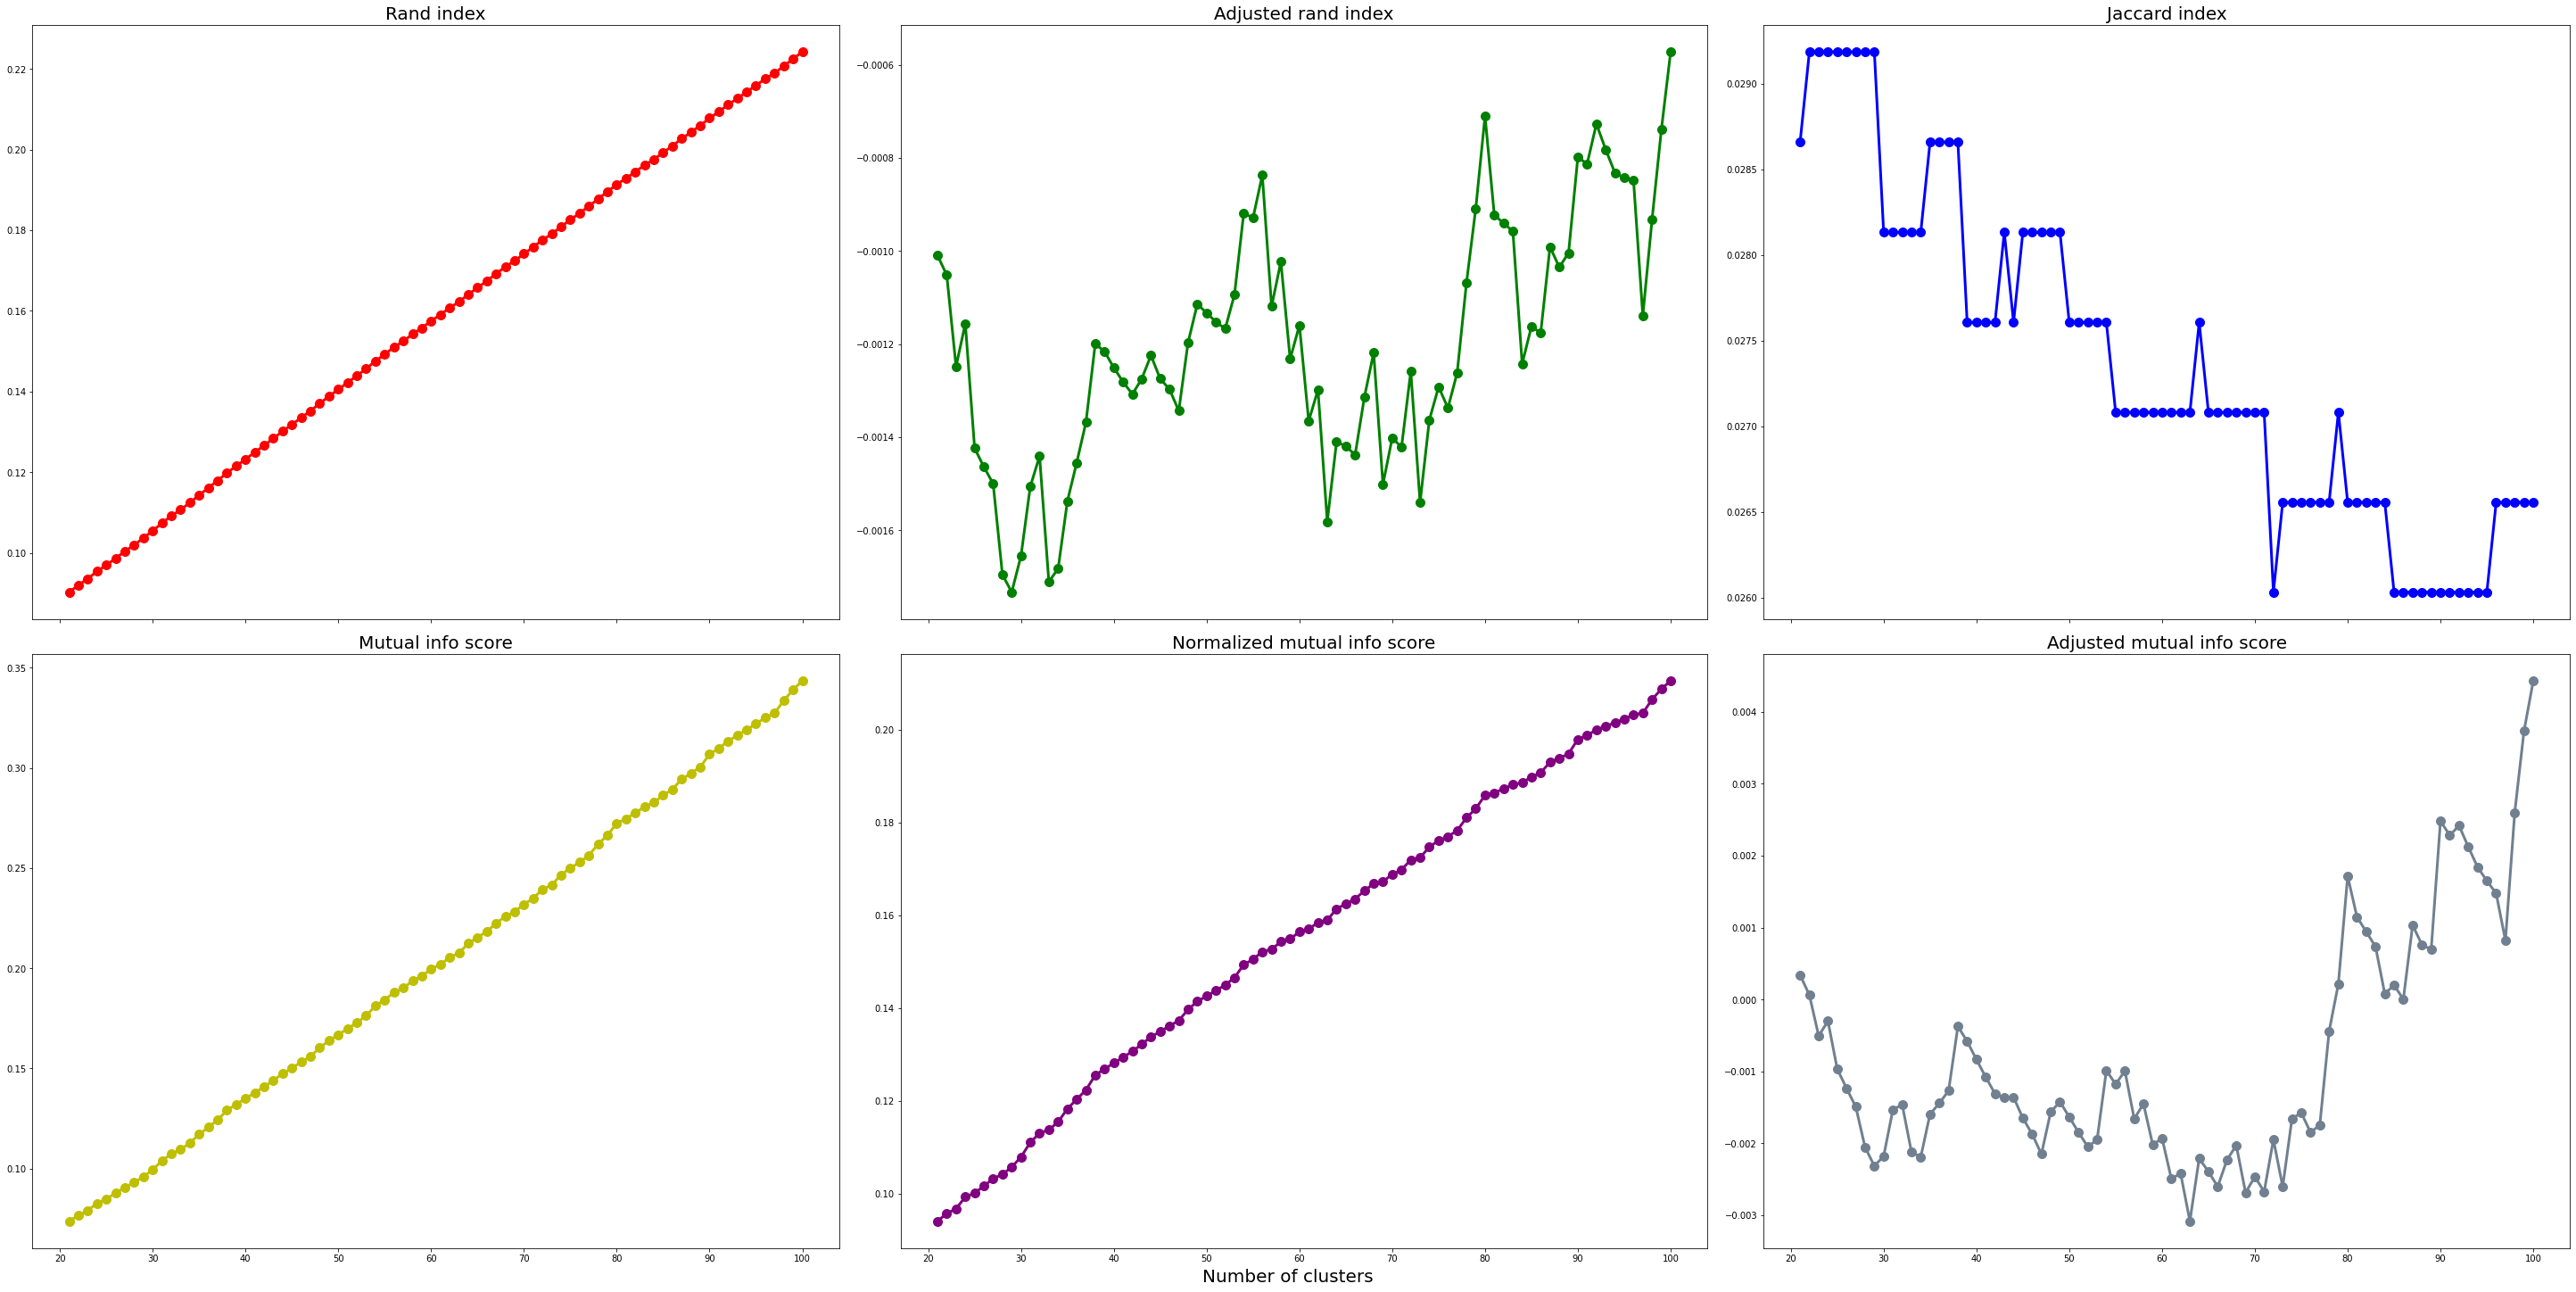

In [ ]:
f, ax = plt.subplots(2, 3, figsize=(40,20), constrained_layout=True, sharex=True)
clusters = np.array(list(rands.keys()))
ax[0, 0].plot(clusters, rands.values(), 'ro-', linewidth=3, markersize=10)
ax[0, 0].set_title('Rand index', fontsize=20)
ax[0, 1].plot(clusters, arands.values(), 'go-', linewidth=3, markersize=10)
ax[0, 1].set_title('Adjusted rand index', fontsize=20)
ax[0, 2].plot(clusters, jaccs.values(), 'bo-', linewidth=3, markersize=10)
ax[0, 2].set_title('Jaccard index', fontsize=20)
ax[1, 0].plot(clusters, muts.values(), 'yo-', linewidth=3, markersize=10)
ax[1, 0].set_title('Mutual info score', fontsize=20)
ax[1, 1].plot(clusters, nmuts.values(), 'o-', color='purple', linewidth=3, markersize=10)
ax[1, 1].set_title('Normalized mutual info score', fontsize=20)
ax[1, 2].plot(clusters, amuts.values(), 'o-', color='slategray', linewidth=3, markersize=10)
ax[1, 2].set_title('Adjusted mutual info score', fontsize=20)
f.supxlabel("Number of clusters", fontsize=20);

In [ ]:
print(f'Лучшее разбиение (Гирван-Ньюман) :\nRand index : {clusters[np.argmax(list(rands.values()))]}\n\
Adjusted rand index : {clusters[np.argmax(list(arands.values()))]}\nJaccard index : {clusters[np.argmax(list(jaccs.values()))]}\nMutual info score : {clusters[np.argmax(list(muts.values()))]}\n\
Normalized mutual info score : {clusters[np.argmax(list(nmuts.values()))]}\nAdjusted mutual info score : {clusters[np.argmax(list(amuts.values()))]}')

Лучшее разбиение (Гирван-Ньюман) :
Rand index : 100
Adjusted rand index : 100
Jaccard index : 22
Mutual info score : 100
Normalized mutual info score : 100
Adjusted mutual info score : 100
